In [3]:
import numpy as np

In [4]:
x = [1000, 2000, 3000]

In [5]:
numerator = np.exp(x)
denominator = np.sum(numerator)

softmax = numerator / denominator
softmax

/tmp/ipykernel_3172559/2174467088.py:1: RuntimeWarning: overflow encountered in exp
  numerator = np.exp(x)
/tmp/ipykernel_3172559/2174467088.py:4: RuntimeWarning: invalid value encountered in divide
  softmax = numerator / denominator


array([nan, nan, nan])

## we got overflow! So we need to do safe softmax.

### 1. minus max trick

In [6]:
x_max = np.max(x)
numerator = np.exp(x - x_max)
denominator = np.sum(numerator)
softmax = numerator / denominator
softmax

array([0., 0., 1.])

The reason why this is working because,

1. exponent negative is closer to 0 but exponent positive is increase infinitely.
2. minus any number does not change the distribution, as long it applied to all numbers.

In [7]:
np.exp(1000), np.exp(-1000)

/tmp/ipykernel_3172559/288047397.py:1: RuntimeWarning: overflow encountered in exp
  np.exp(1000), np.exp(-1000)


(inf, 0.0)

### 2. LSE trick

Log(A/B) = Log(A) − Log(B)

LSE = Log Sum Exponent, which is the denominator, or Log(B).

While Log(A) = Log(exp(A)) = A.

but this one you got log softmax.

In [8]:
log_softmax = x - (x_max + np.log(np.sum(np.exp(x - x_max))))
log_softmax

array([-2000., -1000.,     0.])

In [9]:
np.exp(log_softmax)

array([0., 0., 1.])

## Online softmax

If you have huge matrix, calculating softmax is very expensive, actually we can do it by iterations by using online softmax, let say if you have 10k size of vector, you do not have to load that entire 10k vector inside memory, you can simply iterate one by one to get the `m` and `d`.

The paper from https://arxiv.org/pdf/1805.02867

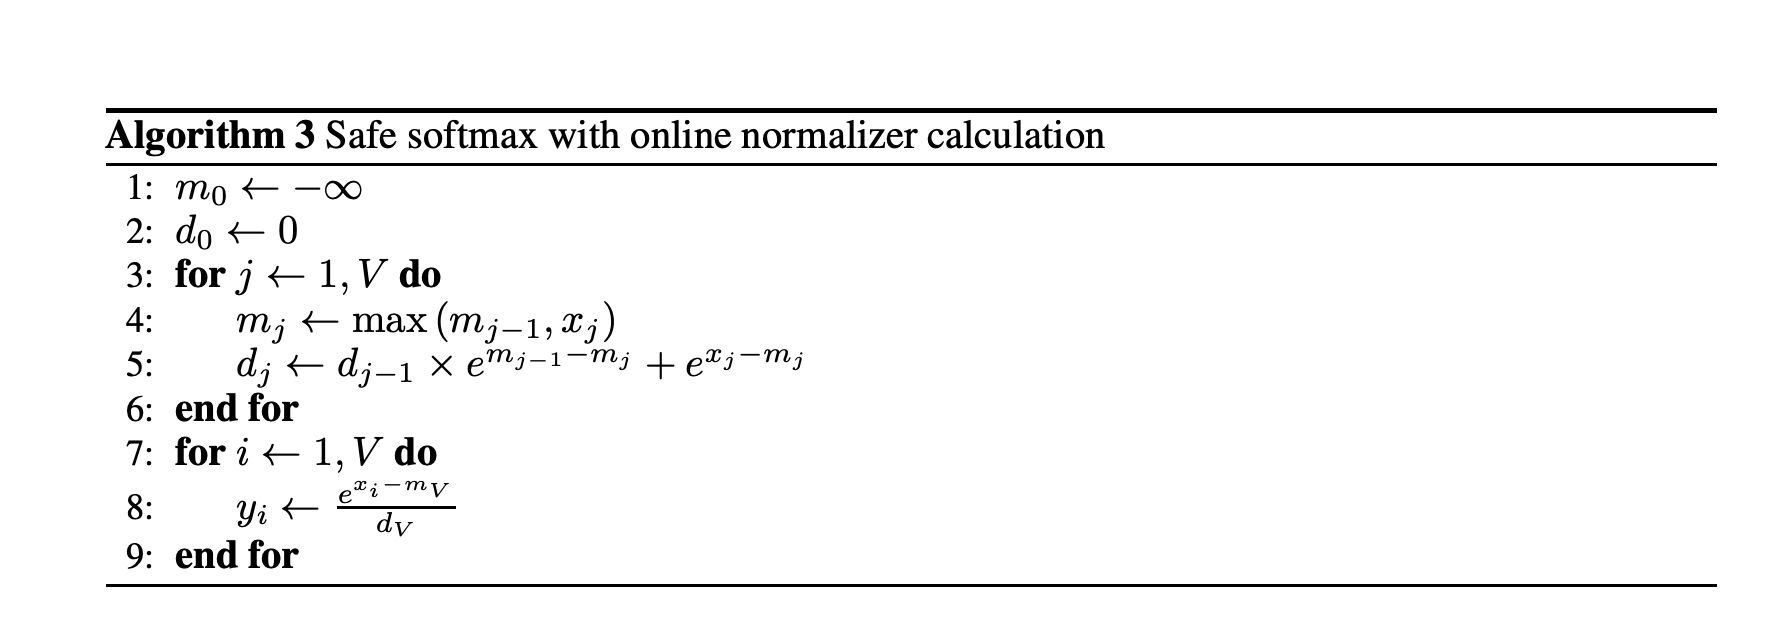

In [13]:
x

[1000, 2000, 3000]

In [14]:
m, d = -np.inf, 0
for x_ in x:
    m_ = max(m, x_)
    d = d * np.exp(m - m_) + np.exp(x_ - m_)
    m = m_

In [15]:
np.exp(np.array(x) - m) / d

array([0., 0., 1.])

### Go bigger

Assume we have a very large matrix, so we split to 10 processes, each processes calculated their own `m` and `d`,

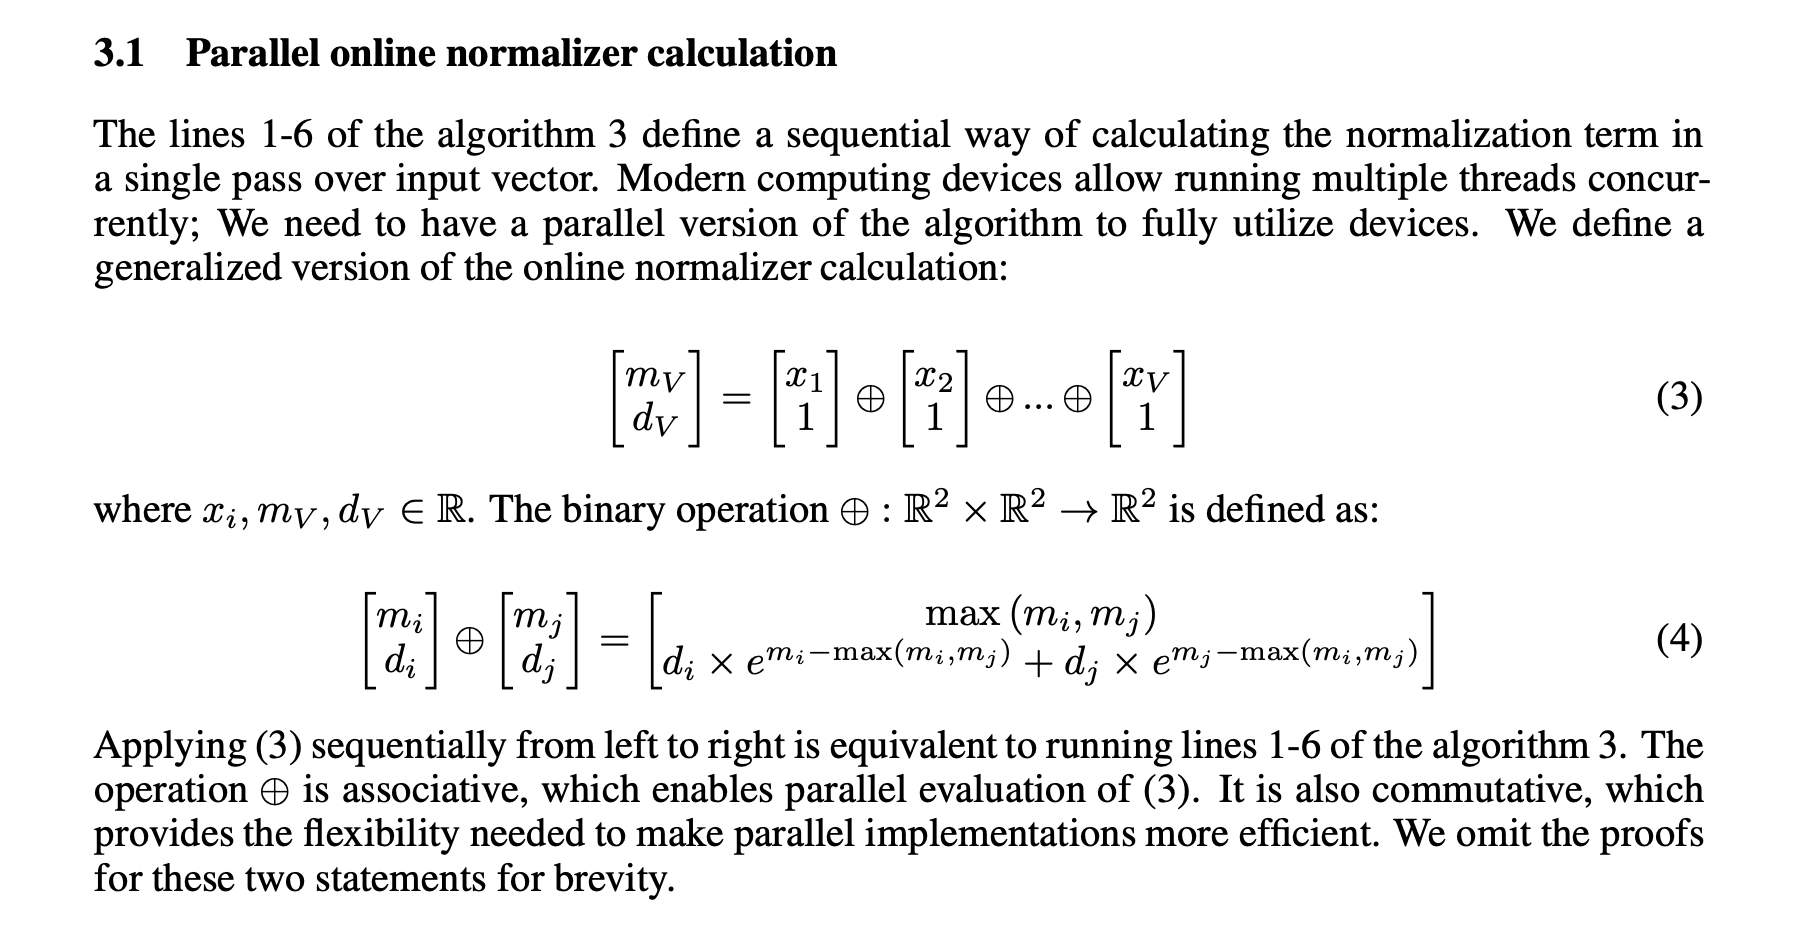

If i have local `m` and `d`, to do global aggregate, you must gather back local `m` and `d`, after that,

1. to get the global `m`, you need to do global max
2. to get the global `d`, you need to do sum of all local `d`.

In [17]:
x = np.random.normal(size = (10000))
splitted = np.split(x, 10)
chunks = []
for s in splitted:
    m, d = -np.inf, 0
    for x_ in s:
        m_ = max(m, x_)
        d = d * np.exp(m - m_) + np.exp(x_ - m_)
        m = m_
    chunks.append((m, d))
    
m_global = -np.inf
for m, _ in chunks:
    m_global = max(m_global, m)

d_global = 0
for m, d in chunks:
    d_global += d * np.exp(m - m_global)

At the end we have to reduce,

In [18]:
m_global = -np.inf
for m, _ in chunks:
    m_global = max(m_global, m)

d_global = 0
for m, d in chunks:
    d_global += d * np.exp(m - m_global)

In [19]:
np.sum(np.exp(x - m_global) / d_global)

1.0

```
splitted = np.split(x, 10)
chunks = []
for s in splitted:
```

this example is using loop but actually you can distribute using multiprocessing and pass to multiGPUs,
1. to get the global `m`, you can do all reduce max.
2. to get the global `d`, you can do all reduce sum.

By doing this, you can parallelize softmax function to any size!